In [1]:
#-------------------------------------------------------------------------------------------------
# Importing Packages, Libraries 
#-------------------------------------------------------------------------------------------------
# Base
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Stats
import sklearn.metrics as ms
import scipy.stats as sts
from scipy import signal

# Viz
import sys
import colorama
from IPython import display
from collections import OrderedDict
import time
import seaborn as sns
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(precision=3)
from torchvision import datasets, transforms

In [2]:
# A fully connected neural net for a 2d image input and a single real number output.
# It is modified from Ziwei's https://github.com/m2lines/team-meetings/blob/main/21-12-01-CNNvsANN/util.py
# By default it builds a neural network with only 1 hidden layer having 10 neurons. 

ip_shp = 2688 # = 56 * 48 (pixel width * pixel height of the image)
class iNet_ANN(nn.Module):
    def __init__(self, neuron_dims=[ip_shp,10,1]):
        super(iNet_ANN, self).__init__()
        self.layers = list()
        self.neuron_dims = neuron_dims
        for i in range(len(self.neuron_dims)-1):
            self.layers.append(nn.Linear(self.neuron_dims[i], self.neuron_dims[i+1]))
        
        # Warp the list of layers
        self.layers = nn.ModuleList(self.layers) 

    def forward(self, x):
        x = x.view(x.shape[0], -1) # vectorizing a 2d image before feeding into the first linear layer
        for i in range(len(self.neuron_dims)-2):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)
        x = x.view(-1)
        return x
    
# same as above but without any nonlinear activations
class iNet_ANN_lin(nn.Module):
    def __init__(self, neuron_dims=[ip_shp,10,1]):
        super(iNet_ANN_lin, self).__init__()
        self.layers = list()
        self.neuron_dims = neuron_dims
        for i in range(len(self.neuron_dims)-1):
            self.layers.append(nn.Linear(self.neuron_dims[i], self.neuron_dims[i+1]))
        
        # Warp the list of layers
        self.layers = nn.ModuleList(self.layers) 

    def forward(self, x):
        x = x.view(x.shape[0], -1) # vectorizing a 2d image before feeding into the first linear layer
        for i in range(len(self.neuron_dims)-2):
            x = self.layers[i](x)
        x = self.layers[-1](x)
        x = x.view(-1)
        return x

In [3]:
# Convolutional neural nets for a 2d image input and a single real number output.

############################################################################    
# Two convolutional layers with two fully connected linear layers at the end
class iNet_CNN_C2L2(nn.Module):
    def __init__(self,channels=[1,1]):
        super(iNet_CNN_C2L2, self).__init__()
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, channels[0], kernel_size=(7, 7),padding=3)),
            ('Tanh1', nn.Tanh()),
            ('S1', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C2', nn.Conv2d(channels[0], channels[1], kernel_size=(5, 5),padding=2)),
            ('Tanh2', nn.Tanh()),
            ('S2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
        ]))

        self.fully_connected = nn.Sequential(OrderedDict([
            ('F1', nn.Linear(168*channels[1], 10)),
            ('Tanh3', nn.Tanh()),
            ('F2', nn.Linear(10, 1)),
        ]))
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)
        output = self.fully_connected(output)
        output = output.view(-1)
        return output
    
###########################################################################    
# Two convolutional layers with one fully connected linear layer at the end
class iNet_CNN_C2L1(nn.Module):
    def __init__(self,channels=[1,1]):
        super(iNet_CNN_C2L1, self).__init__()
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, channels[0], kernel_size=(7, 7),padding=3)),
            ('Tanh1', nn.Tanh()),
            ('S1', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C2', nn.Conv2d(channels[0], channels[1], kernel_size=(5, 5),padding=2)),
            ('Tanh2', nn.Tanh()),
            ('S2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
        ]))


        self.fully_connected = nn.Sequential(OrderedDict([
            ('F1', nn.Linear(168*channels[1], 1)),
        ]))
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)
        output = self.fully_connected(output)
        output = output.view(-1)
        return output
    
###########################################################################
# Two convolutional layers with one fully connected linear layer at the end and without any nonlinear activations
class iNet_CNN_C2L1_lin(nn.Module):
    def __init__(self,channels=[1,1]):
        super(iNet_CNN_C2L1_lin, self).__init__()
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, channels[0], kernel_size=(7, 7),padding=3)),
            ('S1', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C2', nn.Conv2d(channels[0], channels[1], kernel_size=(5, 5),padding=2)),
            ('S2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
        ]))


        self.fully_connected = nn.Sequential(OrderedDict([
            ('F1', nn.Linear(168*channels[1], 1)),
        ]))
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)
        output = self.fully_connected(output)
        output = output.view(-1)
        return output

###########################################################################
# One convolutional layer with one fully connected linear layer at the end    
class iNet_CNN_C1L1(nn.Module):
    def __init__(self,channels=[1,0]):
        super(iNet_CNN_C1L1, self).__init__()
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, channels[0], kernel_size=(7, 7),padding=3)),
            ('Tanh1', nn.Tanh()),
            ('S1', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
        ]))

        self.fully_connected = nn.Sequential(OrderedDict([
            ('F1', nn.Linear(672*channels[0], 1)),
        ]))
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)
        output = self.fully_connected(output)
        output = output.view(-1)
        return output
    
###########################################################################
# One convolutional layer with one fully connected linear layer at the end and without any nonlinear activations
class iNet_CNN_C1L1_lin(nn.Module):
    def __init__(self,channels=[1,0]):
        super(iNet_CNN_C1L1_lin, self).__init__()
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, channels[0], kernel_size=(7, 7),padding=3)),
            ('S1', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
        ]))

        self.fully_connected = nn.Sequential(OrderedDict([
            ('F1', nn.Linear(672*channels[0], 1)),
        ]))
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)
        output = self.fully_connected(output)
        output = output.view(-1)
        return output
    
    

In [4]:
# Damped persistence benchmark
def damp_pers(ips,lead,l1_acc):
    #print(ips.shape)
    ops = np.ones_like(ips)*np.nan
    ops = (l1_acc**lead)*ips
    return ops

In [5]:
# A function for training the NN   
def train_nn(model, train_loader, val_loader,tloader,vloader,device, e=1,num_epochs=10, lr=0.005):
    """ A function to train the neural network. Also computes and stores accuracy after each epoch
    """
    # defining an optimizer and a loss function
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # initializing arrays for storing mse and acc for train/test datasets at the end of each epoch
    # suffix, dp indicates corresponding mse and acc values for the damped persistence benchmark
    acc = np.ones([2,num_epochs])*np.nan
    mse = np.ones([2,num_epochs])*np.nan
    acc_dp = np.ones([2,num_epochs])*np.nan
    mse_dp = np.ones([2,num_epochs])*np.nan
    
    for epoch in range(num_epochs):
        print("=" * 40, "Starting epoch %d" % (epoch + 1), "=" * 40)
        model.train()  
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        
        # Compute the train and test accuracy at the end of each epoch
        mse[0,epoch],acc[0,epoch],mse_dp[0,epoch],acc_dp[0,epoch] = accuracy(model,tloader, device)
        mse[1,epoch],acc[1,epoch],mse_dp[1,epoch],acc_dp[1,epoch] = accuracy(model, vloader, device)
        
        # saving model at the end of each epoch
        name = 'ens' + str(e) + '_ep' + str(epoch)
        torch.save(model.state_dict(), odir + '/' + name + '.pt')
        
        # print mse and acc for training dataset after each epoch     
        print(colorama.Fore.GREEN, "MSE, ACC on training: (%.3f,%.3f)" % (mse[0,epoch],acc[0,epoch]))
        print("MSE, ACC of Damped Persistence on training: (%.3f,%.3f)" % (mse_dp[0,epoch],acc_dp[0,epoch]), colorama.Fore.RESET)
    return mse,acc,mse_dp,acc_dp
    

# A function for measuring accuracy    
def accuracy(model, dataloader, device):
    """ Computes the model's accuracy on the data provided by 'dataloader'
    """
    model.eval()
    
    err = 0
    cor = 0
    err1 = 0
    cor1 = 0
    with torch.no_grad(): 
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            #predictions = model(data).view(-1).numpy() 
            predictions = model(data).view(-1).cpu().numpy()
            #labels = labels.numpy()
            labels = labels.cpu().numpy()
            err += ms.mean_squared_error(predictions,labels)
            cor += sts.pearsonr(predictions,labels)[0]
            #pred = damp_pers(data[:,nmon-1,box[2]:box[3],box[0]:box[1]].mean(axis=-1).mean(axis=-1).numpy(),lead = lead,l1_acc=l1_acc)
            pred = damp_pers(data[:,nmon-1,box[2]:box[3],box[0]:box[1]].mean(axis=-1).mean(axis=-1).cpu().numpy(),lead = lead,l1_acc=l1_acc)
            err1 += ms.mean_squared_error(pred,labels)
            cor1 += sts.pearsonr(pred,labels)[0]
        
    return err/len(dataloader),cor/len(dataloader),err1/len(dataloader),cor1/len(dataloader)

In [6]:
# Data formating for pytorch     
def prep_labels_samples_unsmooth(dat_train,dat_val,lead=1):
    labels = dat_train[1+nmon+1*(lead-2):-3+2,box[2]:box[3],box[0]:box[1]]
    labels = labels.mean(axis=-1).mean(axis=-1)
    samples = np.expand_dims(dat_train[:-nmon,:,:],axis=1)
    for i in range(1,nmon):
        samples = np.concatenate([samples,np.expand_dims(dat_train[i:-nmon+i,:,:],axis=1)],axis=1)
    
    samples = samples[:labels.shape[0]]   
    samples = torch.Tensor(samples)
    labels = torch.Tensor(labels)

    train_dataset = torch.utils.data.TensorDataset(samples,labels)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs_tr, shuffle=True)
    l1_acc = sts.pearsonr(labels[:-1],labels[1:])[0]
    
    labels = dat_val[1+nmon+1*(lead-2):-3+2,box[2]:box[3],box[0]:box[1]]
    labels = labels.mean(axis=-1).mean(axis=-1)
    samples = np.expand_dims(dat_val[:-nmon,:,:],axis=1)
    for i in range(1,nmon):
        samples = np.concatenate([samples,np.expand_dims(dat_val[i:-nmon+i,:,:],axis=1)],axis=1)
    
    samples = samples[:labels.shape[0]]
    samples = torch.Tensor(samples)
    labels = torch.Tensor(labels)
    val_dataset = torch.utils.data.TensorDataset(samples,labels)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs_va, shuffle=True)
    del dat_train,dat_val
    
    return train_dataset,train_loader,l1_acc,val_dataset,val_loader

In [ ]:
# Given the data has been preprocessed and stored in 'dat_train' and 'dat_val' variables, this cell demonstrates a sample training
# of 'iNet_CNN_C2L1()' neural net for lead=6 months. 
# In these examples, the dimensions of 'dat_train' and 'dat_val' variables are (9600, 56, 48) 

nmon = 1
bs_tr = 1000
bs_va = 1000
ip_ch = nmon

start_time = datetime.now()

rep = 1
ep = 50
lr =.001
channels = [1,1]

for lead in [6]:
    train_dataset,train_loader,l1_acc,val_dataset,val_loader = prep_labels_samples_unsmooth(dat_train,dat_val,lead=lead)
    tloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    vloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    odir = mod_pdir + 'C2L1_c' + str(channels[0]) + 'c' + str(channels[1]) +'_lead' + str(lead)+'_nmon' + str(nmon)+'_bs' + str(bs_tr) + '_ilr' + str(np.int(1./lr)) + '_ntr'+ str(ntrain) + '_ep' + str(ep) + '_rep' + str(rep) + '_' + str(device)
    print(odir)
    os.makedirs(odir, exist_ok=True)
    os.makedirs(res_pdir, exist_ok=True)
    mse = np.zeros([4,rep,ep])
    acc = np.zeros([4,rep,ep])
    for i in range(rep):
        conv_net = iNet_CNN_C2L1(channels=channels)
        nparams = sum(map(torch.numel, conv_net.parameters()))
        print('No. of parameters : ', nparams)
        conv_net = conv_net.to(device)
        m,a,md,ad = train_nn(conv_net, train_loader, val_loader, tloader,vloader, device,e=i+1,num_epochs=ep,lr=lr)
        mse[0,i]=m[0];mse[1,i]=m[1]
        acc[0,i]=a[0];acc[1,i]=a[1]
        mse[2,i]=md[0];acc[2,i]=ad[0]
        mse[3,i]=md[1];acc[3,i]=ad[1]
        del conv_net
    

    np.savez(res_pdir + 'C2L1_c' + str(channels[0]) + 'c' + str(channels[1]) +'_lead' + str(lead)+'_nmon' + str(nmon)+'_bs' + str(bs_tr) + '_ilr' + str(np.int(1./lr)) + '_ntr'+ str(ntrain) + '_ep' + str(ep) + '_rep' + str(rep) + '_' + str(device) + '.npz',mse=mse,acc=acc)
    del train_dataset,train_loader,l1_acc,val_dataset,val_loader
    
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [7]:
def plot_mse(ax,fname,ttl,ylim=None,legend=False):
    tmp = np.load(fname)
    plt.sca(ax)
    ax.set_title(ttl,fontsize=14,family='serif',y=.98)
    plt.plot(range(1,ep+1),tmp['mse'][2,0],'r-',lw=2.,alpha=.99,label='dPersistence')
    plt.plot(range(1,ep+1),tmp['mse'][0].T,'k-',lw=.5,alpha=.8)
    plt.plot(range(1,ep+1),tmp['mse'][0].mean(axis=0),'k-',lw=1.5,alpha=.8,label='NN_train')
    plt.plot(range(1,ep+1),tmp['mse'][1].T,'b--',lw=.5,alpha=.7)
    plt.plot(range(1,ep+1),tmp['mse'][1].mean(axis=0),'b--',lw=2.,alpha=.7,label='NN_test')
    plt.fill_between(range(1,ep+1),tmp['mse'][1].mean(axis=0),tmp['mse'][2].mean(axis=0),where=tmp['mse'][1].mean(axis=0)<tmp['mse'][2].mean(axis=0),facecolor='yellow',alpha=.2)
    ax.set_xlabel('epoch',fontsize=14,family='serif')
    ax.set_ylabel('MSE',fontsize=14,family='serif')
    ax.set_xticks(range(0,51,8))
    ax.set_xticklabels(range(0,51,8),fontsize=13,family='serif')
    ax.set_xlim(0,51)
    ax.set_yticks(np.arange(0,2,.05))
    if ylim == None:
        ax.set_ylim([tmp['mse'].min()-.02,tmp['mse'].max()+.02])
    else:
        ax.set_ylim(ylim)
    ax.set_yticklabels(['%.2f' %j for j in ax.get_yticks()],fontsize=13,family='serif')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.grid('--',lw=.1)
    if legend == True:
        ax.legend(loc=3,fontsize=13.5,frameon=False,bbox_to_anchor=(0.,1.5),ncol=1)

    


In [8]:
# Plotting learning curves for fully connected networks for lead = 6 months
res_pd = '.../results_v1/'
fnames = sorted(glob.glob(res_pd + '*lead6*.npz'))
print(len(fnames))
for f in fnames:
    print(f.split('/')[-1])

print('\n\n\n')


13
C1L1_c1c0_lead6_nmon1_bs1000_ilr10000_ntr8_ep50_rep10_cuda.npz
C1L1_c1c0_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep10_cuda.npz
C1L1_lin_c1c0_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep10_cuda.npz
C2L1_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_lin_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L2_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L2_c3c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L2_c3c3_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
L1_lead6_nmon1_bs1000_ilr10000_ntr8_ep50_rep5_cuda.npz
L1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
L1_lin_lead6_nmon1_bs1000_ilr10000_ntr8_ep50_rep5_cuda.npz
L1_lin_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
L2_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz






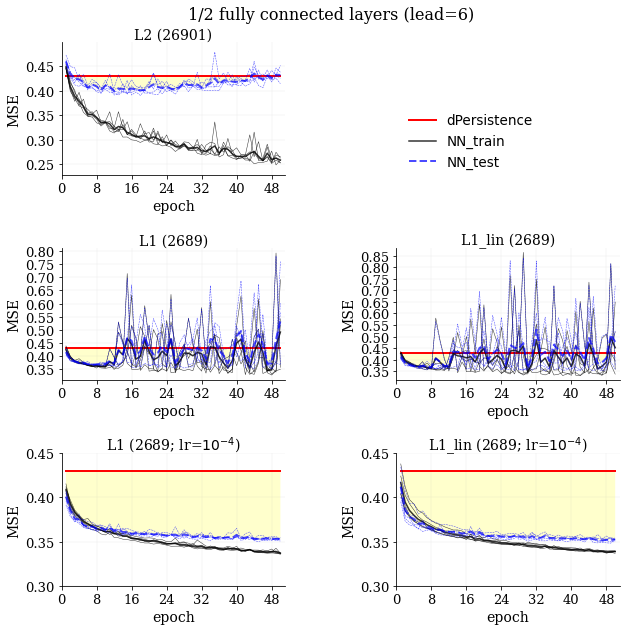

In [157]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
plt.suptitle('1/2 fully connected layers (lead=6)',fontsize=16,family='serif',y=.93)

tmp_nn = iNet_ANN(neuron_dims=[ip_shp,10,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[12]
ttl = f.split('/')[-1][0:2] + ' (' + str(npar) + ')'
plot_mse(axs[0,0],f,ttl)

fig.delaxes(axs[0,1])

tmp_nn = iNet_ANN(neuron_dims=[ip_shp,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[9]
ttl = f.split('/')[-1][0:2] + ' (' + str(npar) + ')'
plot_mse(axs[1,0],f,ttl)

tmp_nn = iNet_ANN(neuron_dims=[ip_shp,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[11]
ttl = f.split('/')[-1][0:6] + ' (' + str(npar) + ')'
plot_mse(axs[1,1],f,ttl,legend=True)

tmp_nn = iNet_ANN(neuron_dims=[ip_shp,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[8]
ttl = f.split('/')[-1][0:2] + ' (' + str(npar) + '; lr=$10^{-4}$)'
plot_mse(axs[2,0],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_ANN(neuron_dims=[ip_shp,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[10]
ttl = f.split('/')[-1][0:6] + ' (' + str(npar) + '; lr=$10^{-4}$)'
plot_mse(axs[2,1],f,ttl,ylim=[.3,.45])

plt.subplots_adjust(hspace=.55,wspace=.5)


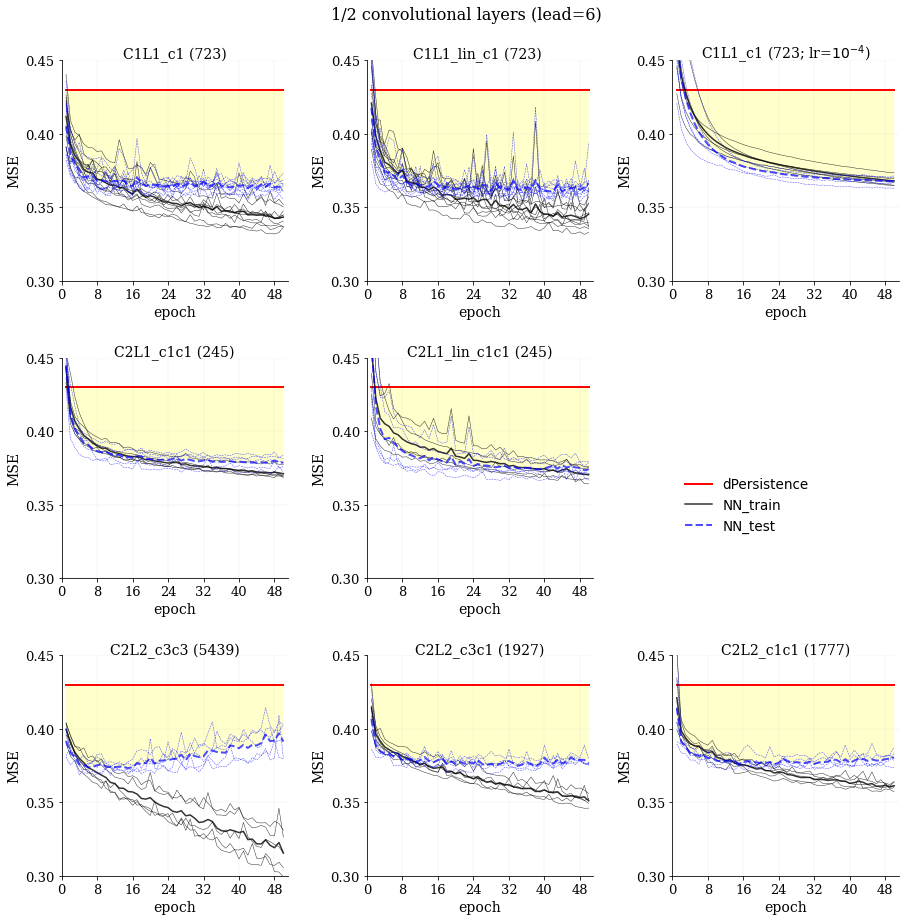

In [155]:
fig,axs = plt.subplots(3,3,figsize=(15,15))
plt.suptitle('1/2 convolutional layers (lead=6)',fontsize=16,family='serif',y=.93)

tmp_nn = iNet_CNN_C2L2(channels=[3,3])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[7]
ttl = f.split('/')[-1][0:9] + ' (' + str(npar) + ')'
plot_mse(axs[2,0],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_CNN_C2L2(channels=[3,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[6]
ttl = f.split('/')[-1][0:9] + ' (' + str(npar) + ')'
plot_mse(axs[2,1],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_CNN_C2L2(channels=[1,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[5]
ttl = f.split('/')[-1][0:9] + ' (' + str(npar) + ')'
plot_mse(axs[2,2],f,ttl,ylim=[.3,.45],legend=True)

tmp_nn = iNet_CNN_C2L1(channels=[1,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[3]
ttl = f.split('/')[-1][0:9] + ' (' + str(npar) + ')'
plot_mse(axs[1,0],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_CNN_C2L1_lin(channels=[1,1])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[4]
ttl = f.split('/')[-1][0:13] + ' (' + str(npar) + ')'
plot_mse(axs[1,1],f,ttl,ylim=[.3,.45])

fig.delaxes(axs[1,2])

tmp_nn = iNet_CNN_C1L1(channels=[1,0])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[1]
ttl = f.split('/')[-1][0:7] + ' (' + str(npar) + ')'
plot_mse(axs[0,0],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_CNN_C1L1(channels=[1,0])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[0]
ttl = f.split('/')[-1][0:7] + ' (' + str(npar) + '; lr=$10^{-4}$)'
plot_mse(axs[0,2],f,ttl,ylim=[.3,.45])

tmp_nn = iNet_CNN_C1L1_lin(channels=[1,0])
npar = sum(map(torch.numel, tmp_nn.parameters()))
f = fnames[2]
ttl = f.split('/')[-1][0:11] + ' (' + str(npar) + ') ' 
plot_mse(axs[0,1],f,ttl,ylim=[.3,.45])

plt.subplots_adjust(hspace=.35,wspace=.35)


In [112]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [192]:
def get_activation1(name):
    def hook(model, input, output):
        activation1[name] = output.detach()
    return hook

In [153]:
nmon = 1
bs_tr = 1000
bs_va = 1000
ip_ch = nmon

lead = 6

train_dataset,train_loader,l1_acc,val_dataset,val_loader = prep_labels_samples_unsmooth(dat_train,dat_val,lead=lead)
tloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
vloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
data = vloader.dataset.tensors[0]
labels = vloader.dataset.tensors[1]
iavg = np.argwhere(np.logical_and(labels[:] <= .5*np.std(labels.numpy()),labels[:] >= -.5*np.std(labels.numpy())))
print(iavg[0].shape)
model = iNet_CNN_C2L2(channels=[3,3])
model.load_state_dict(torch.load('.../models_v1/C2L2_c3c3_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep5.pt'))
model.eval()
activation = {}
model.conv_net.C2.register_forward_hook(get_activation('C2'))
output = model(data[iavg[0]])

torch.Size([3846])


In [177]:
nmon = 1
bs_tr = 1000
bs_va = 1000
ip_ch = nmon

lead = 6

train_dataset,train_loader,l1_acc,val_dataset,val_loader = prep_labels_samples_unsmooth(dat_train,dat_val,lead=lead)
tloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
vloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
data = vloader.dataset.tensors[0]
labels = vloader.dataset.tensors[1]
iavg = np.argwhere(np.logical_and(labels[:] <= .5*np.std(labels.numpy()),labels[:] >= -.5*np.std(labels.numpy())))
print(iavg[0].shape)
model = iNet_CNN_C2L2(channels=[3,3])
model.load_state_dict(torch.load('.../models_v1/C2L2_c3c3_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep49.pt'))
model.eval()
activation = {}
model.conv_net.C1.register_forward_hook(get_activation('C1'))
output = model(data[iavg[0]])
print(output[11],labels[iavg[0]][11])

torch.Size([3846])
tensor(-0.462, grad_fn=<SelectBackward>) tensor(0.237)


In [258]:
nmon = 1
bs_tr = 1000
bs_va = 1000
ip_ch = nmon

lead = 6

train_dataset,train_loader,l1_acc,val_dataset,val_loader = prep_labels_samples_unsmooth(dat_train,dat_val,lead=lead)
tloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
vloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
data = vloader.dataset.tensors[0]
labels = vloader.dataset.tensors[1]
iavg = np.argwhere(np.logical_and(labels[:] <= .5*np.std(labels.numpy()),labels[:] >= -.5*np.std(labels.numpy())))
imax = np.argwhere(labels[:] >= 1.5*np.std(labels.numpy()))
print(iavg[0].shape,imax[0].shape)

torch.Size([3846]) torch.Size([651])


In [259]:
model1 = iNet_CNN_C2L1(channels=[1,1])
model1.load_state_dict(torch.load('.../models_v1/C2L1_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep20.pt'))
model1.eval()
activation = {}
model1.conv_net.S1.register_forward_hook(get_activation('S1'))
output1 = model1(data[iavg[0]])

In [260]:
model2 = iNet_CNN_C2L2(channels=[3,3])
model2.load_state_dict(torch.load('.../models_v1/C2L2_c3c3_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep30.pt'))
model2.eval()
activation1 = {}
model2.conv_net.S1.register_forward_hook(get_activation1('S1'))
output2 = model2(data[iavg[0]])

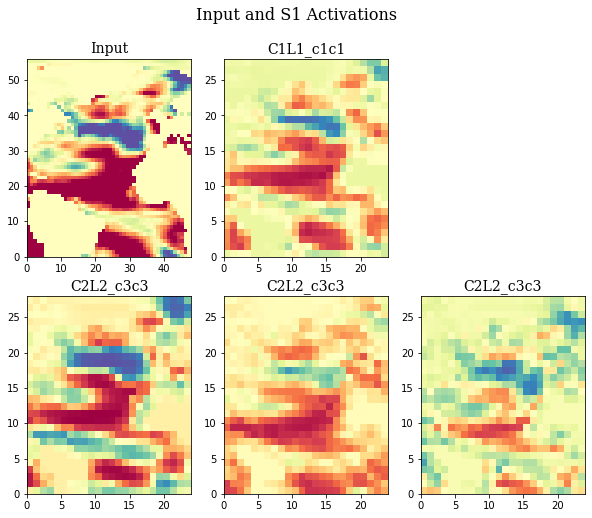

In [264]:
fig,axs = plt.subplots(2,3,figsize=(10,8))
plt.suptitle('Input and S1 Activations',fontsize=16,family='serif',y=.97)

axs[0,0].pcolor(np.array(data[iavg[0]][65][0]),vmin=-1,vmax=1,cmap=plt.cm.Spectral_r)
axs[0,0].set_title('Input',fontsize=14,family='serif')

axs[0,1].pcolor(1.*np.array(activation['S1'][65,0].data),vmin=-1,vmax=1,cmap=plt.cm.Spectral_r)
axs[0,1].set_title('C1L1_c1c1',fontsize=14,family='serif')
fig.delaxes(axs[0,2])

axs[1,0].pcolor(-1.*np.array(activation1['S1'][65,0].data),vmin=-1,vmax=1,cmap=plt.cm.Spectral_r)
axs[1,0].set_title('C2L2_c3c3',fontsize=14,family='serif')

axs[1,1].pcolor(1.*np.array(activation1['S1'][65,1].data),vmin=-1,vmax=1,cmap=plt.cm.Spectral_r)
axs[1,1].set_title('C2L2_c3c3',fontsize=14,family='serif')

axs[1,2].pcolor(-1.*np.array(activation1['S1'][65,2].data),vmin=-1,vmax=1,cmap=plt.cm.Spectral_r)
axs[1,2].set_title('C2L2_c3c3',fontsize=14,family='serif')


In [18]:
# Plotting MSE and ACC skill for lead=1 to 24 months for selected NNs 
res_pd = '.../results_v1/'
fnames1 = sorted(glob.glob(res_pd + 'C1L1_c1c0*lead?_*ilr1000_*rep*.npz'))
fnames2 = sorted(glob.glob(res_pd + 'C1L1_c1c0*lead??_*ilr1000_*rep*.npz'))
fnames = fnames1 + fnames2
print(len(fnames))
for f in fnames:
    print(f.split('/')[-1])

print('\n\n\n')


24
C1L1_c1c0_lead1_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead2_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead3_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead4_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead5_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep10_cuda.npz
C1L1_c1c0_lead7_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead8_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead9_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead10_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead11_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead12_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead13_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead14_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead15_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lead16_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C1L1_c1c0_lea

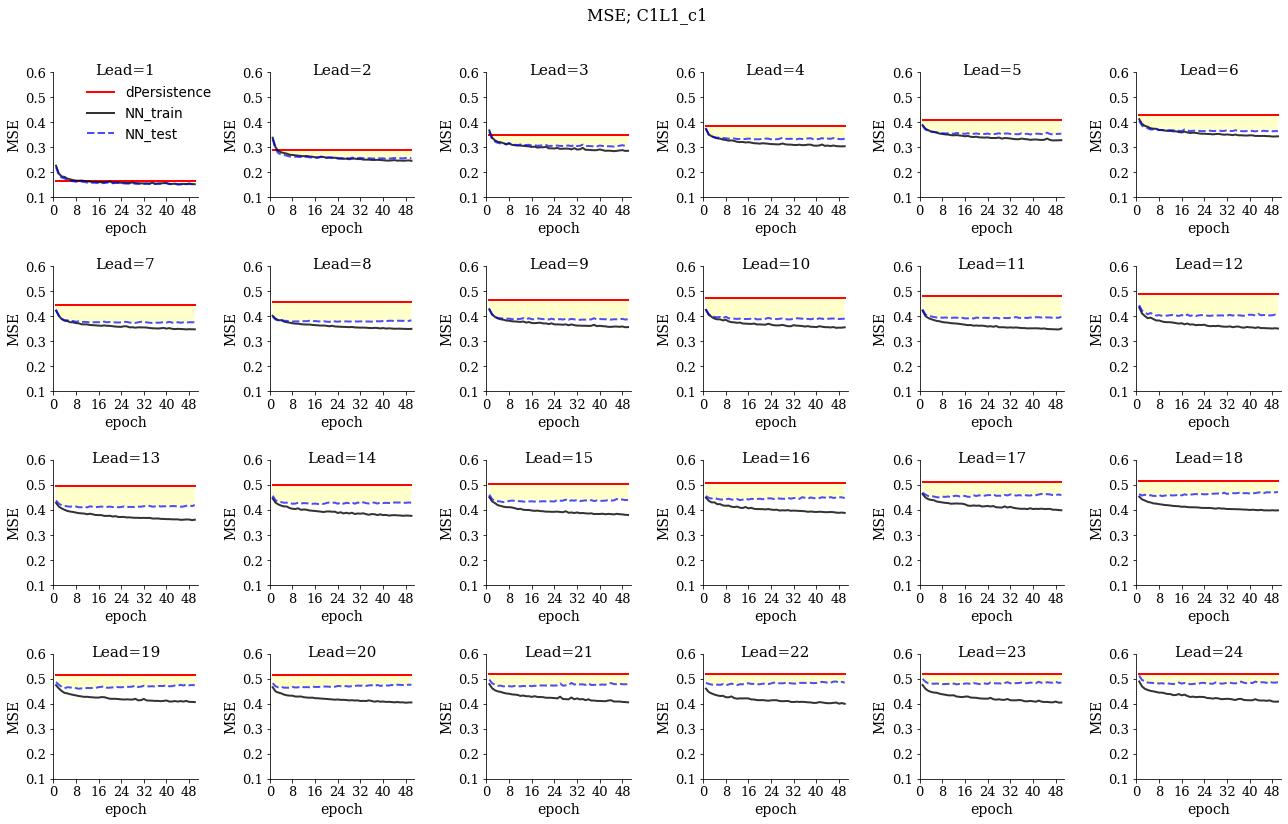

In [42]:
ep = 50
fig = plt.figure(figsize=(22,13))
axs = []
plt.suptitle('MSE; C1L1_c1',fontsize=16,family='serif',y=.95)
for i,f in enumerate(fnames[:]):
    axs.append(fig.add_subplot(4,6,i+1))
    plt.sca(axs[i])
    axs[i].set_title('Lead=%d' %((i+1)),fontsize=15,family='serif',y=.93)
    tmp = np.load(f)
    plt.plot(range(1,ep+1),tmp['mse'][2,0],'r-',lw=2.,alpha=.99,label='dPersistence')
    plt.plot(range(1,ep+1),tmp['mse'][0].mean(axis=0),'k-',lw=2.,alpha=.8,label='NN_train')
    plt.plot(range(1,ep+1),tmp['mse'][1].mean(axis=0),'b--',lw=2.,alpha=.7,label='NN_test')
    plt.fill_between(range(1,ep+1),tmp['mse'][1].mean(axis=0),tmp['mse'][2,0],where=tmp['mse'][1].mean(axis=0)<tmp['mse'][2,0],facecolor='yellow',alpha=.2)
    #print(tmp['mse'][1,0].shape,epind_ohc[i])
    axs[i].set_xlabel('epoch',fontsize=14,family='serif')
    axs[i].set_ylabel('MSE',fontsize=14,family='serif')
    axs[i].set_xticks(range(0,51,8))
    axs[i].set_xticklabels(range(0,51,8),fontsize=13,family='serif')
    axs[i].set_xlim(0,51)
    axs[i].set_yticks(np.arange(0,2,.1))
    axs[i].set_ylim([0.1,.6])
    
    axs[i].set_yticklabels(['%.1f' %j for j in axs[i].get_yticks()],fontsize=13,family='serif')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].yaxis.set_ticks_position('left')
    axs[i].xaxis.set_ticks_position('bottom')

axs[0].legend(loc=3,fontsize=13.5,frameon=False,bbox_to_anchor=(.15,.35),ncol=1)

plt.subplots_adjust(hspace=.55,wspace=.5)

In [44]:
mse_c1l1 = np.ones([2,24])
acc_c1l1 = np.ones([2,24])

for i,f in enumerate(fnames):
    tmp = np.load(f)
    mse_c1l1[0,i] = tmp['mse'][2,:,stop_inds[i]].mean()
    mse_c1l1[1,i] = tmp['mse'][1,:,stop_inds[i]].mean()
    acc_c1l1[0,i] = tmp['acc'][2,:,stop_inds[i]].mean()
    acc_c1l1[1,i] = tmp['acc'][1,:,stop_inds[i]].mean()
    

In [47]:
# Plotting MSE and ACC skill for lead=1 to 24 months for selected NNs 
res_pd = '.../results_v1/'
fnames1 = sorted(glob.glob(res_pd + 'C2L1_c1c1*lead?_*ilr1000_*rep*.npz'))
fnames2 = sorted(glob.glob(res_pd + 'C2L1_c1c1*lead??_*ilr1000_*rep*.npz'))
fnames = fnames1 + fnames2
print(len(fnames))
for f in fnames:
    print(f.split('/')[-1])

print('\n\n\n')

24
C2L1_c1c1_lead1_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead2_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead3_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead4_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead5_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead7_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead8_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead9_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead10_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead11_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead12_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead13_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead14_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead15_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead16_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda.npz
C2L1_c1c1_lead

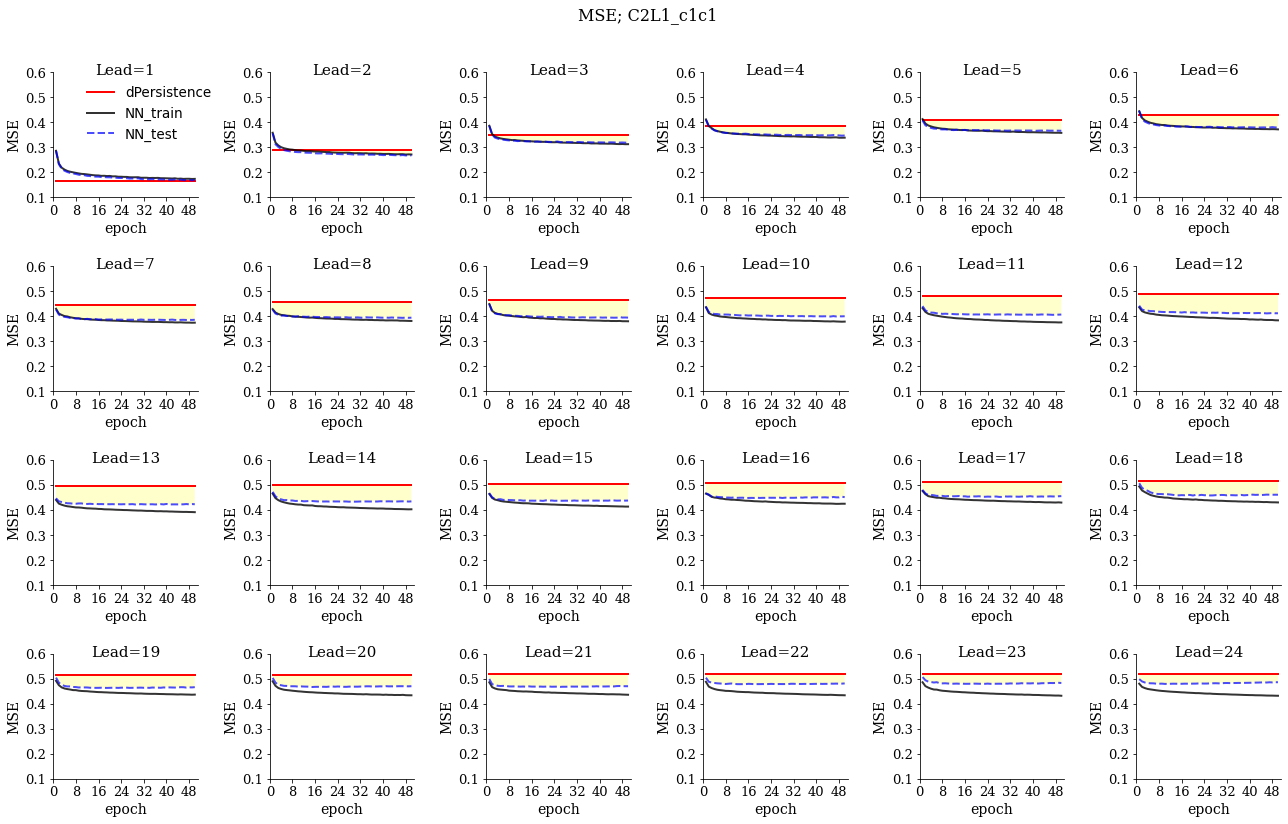

In [48]:
ep = 50
fig = plt.figure(figsize=(22,13))
axs = []
plt.suptitle('MSE; C2L1_c1c1',fontsize=16,family='serif',y=.95)
for i,f in enumerate(fnames[:]):
    axs.append(fig.add_subplot(4,6,i+1))
    plt.sca(axs[i])
    axs[i].set_title('Lead=%d' %((i+1)),fontsize=15,family='serif',y=.93)
    tmp = np.load(f)
    plt.plot(range(1,ep+1),tmp['mse'][2,0],'r-',lw=2.,alpha=.99,label='dPersistence')
    plt.plot(range(1,ep+1),tmp['mse'][0].mean(axis=0),'k-',lw=2.,alpha=.8,label='NN_train')
    plt.plot(range(1,ep+1),tmp['mse'][1].mean(axis=0),'b--',lw=2.,alpha=.7,label='NN_test')
    plt.fill_between(range(1,ep+1),tmp['mse'][1].mean(axis=0),tmp['mse'][2,0],where=tmp['mse'][1].mean(axis=0)<tmp['mse'][2,0],facecolor='yellow',alpha=.2)
    #print(tmp['mse'][1,0].shape,epind_ohc[i])
    axs[i].set_xlabel('epoch',fontsize=14,family='serif')
    axs[i].set_ylabel('MSE',fontsize=14,family='serif')
    axs[i].set_xticks(range(0,51,8))
    axs[i].set_xticklabels(range(0,51,8),fontsize=13,family='serif')
    axs[i].set_xlim(0,51)
    axs[i].set_yticks(np.arange(0,2,.1))
    axs[i].set_ylim([0.1,.6])
    
    axs[i].set_yticklabels(['%.1f' %j for j in axs[i].get_yticks()],fontsize=13,family='serif')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].yaxis.set_ticks_position('left')
    axs[i].xaxis.set_ticks_position('bottom')

axs[0].legend(loc=3,fontsize=13.5,frameon=False,bbox_to_anchor=(.15,.35),ncol=1)

plt.subplots_adjust(hspace=.55,wspace=.5)

In [106]:
stop_c2l1 = [49,49,40,32,32,32,24,16,16,5,5,5,3,3,5,5,5,5,5,3,3,1,1,1]
nmon = 1
bs_tr = 1000
bs_va = 1000
ip_ch = nmon

mm_lb = list(range(0,12))*800
print(len(mm_lb))

mons_lb = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
rmse_c2l1_v2 = np.ones([24])*np.nan
acc_c2l1_v2 = np.ones([24])*np.nan

for l in range(1,25):
    i = l - 1
    l1_acc,val_dataset,val_loader,mm_i,mm_t = prep_labels_samples_unsmooth_old(dat_train,dat_val,lead=l)[-5:]
    data = val_loader.dataset.tensors[0]
    labels = val_loader.dataset.tensors[1]
    #print(data.shape,labels.shape)
    lead = str(l)
    fin_ep = stop_c2l1[i]
    pd = './models_v1/C2L1_c1c1_lead' + lead + '_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/'
    fname = 'ens1_ep' + str(fin_ep) + '.pt'
    print(pd + fname)
    model = iNet_CNN_C2L1(channels=[1,1])
    model.load_state_dict(torch.load(pd + fname))
    model.eval()
    output = model(data[:].data).detach().numpy()
    tmp_labels = np.array(labels.data)
    #print(output.shape,tmp_labels.shape)
    rmse_c2l1_v2[i] = ms.mean_squared_error(output,tmp_labels)
    acc_c2l1_v2[i] = sts.pearsonr(output,tmp_labels)[0]



9600
./models_v1/C2L1_c1c1_lead1_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep49.pt
./models_v1/C2L1_c1c1_lead2_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep49.pt
./models_v1/C2L1_c1c1_lead3_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep40.pt
./models_v1/C2L1_c1c1_lead4_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep32.pt
./models_v1/C2L1_c1c1_lead5_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep32.pt
./models_v1/C2L1_c1c1_lead6_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep32.pt
./models_v1/C2L1_c1c1_lead7_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep24.pt
./models_v1/C2L1_c1c1_lead8_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep16.pt
./models_v1/C2L1_c1c1_lead9_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep16.pt
./models_v1/C2L1_c1c1_lead10_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep5.pt
./models_v1/C2L1_c1c1_lead11_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep5.pt
./models_v1/C2L1_c1c1_lead12_nmon1_bs1000_ilr1000_ntr8_ep50_rep5_cuda/ens1_ep5.pt
./models_v1

In [52]:
mse_c2l1 = np.ones([2,24])
acc_c2l1 = np.ones([2,24])

for i,f in enumerate(fnames):
    tmp = np.load(f)
    mse_c2l1[0,i] = tmp['mse'][2,:,stop_c2l1[i]].mean()
    mse_c2l1[1,i] = tmp['mse'][1,:,stop_c2l1[i]].mean()
    acc_c2l1[0,i] = tmp['acc'][2,:,stop_c2l1[i]].mean()
    acc_c2l1[1,i] = tmp['acc'][1,:,stop_c2l1[i]].mean()

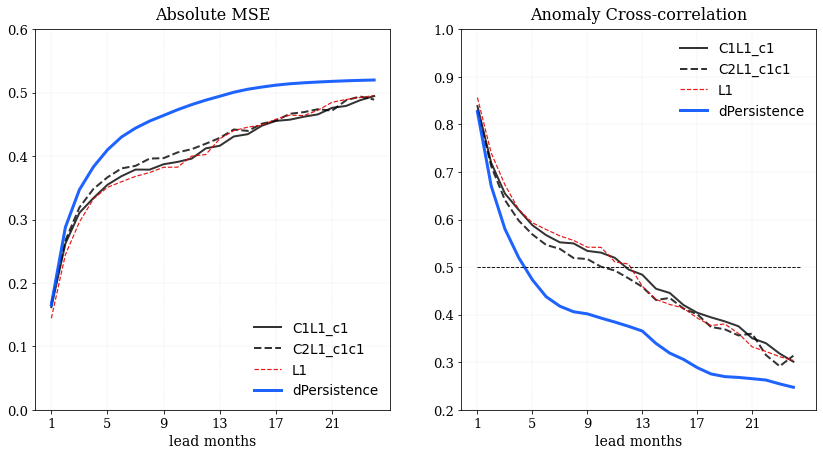

In [111]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.sca(ax1)
plt.plot(range(24),mse_c1l1[1],'k-',lw=2.,alpha=.8,label='C1L1_c1')
plt.plot(range(24),mse_c2l1[1],'k--',lw=2.,alpha=.8,label='C2L1_c1c1')
plt.plot(range(24),mse_l1[1],'--',color=sns.xkcd_rgb['red'],lw=1.2,alpha=.9,label='L1')
plt.plot(range(24),mse_c1l1[0],'-',color=sns.xkcd_rgb['electric blue'],lw=3,alpha=.9,label='dPersistence')
ax1.set_title('Absolute MSE',fontsize=16,family='serif',y=1.01)
plt.grid(lw=.15,linestyle='-.')
ax1.set_xticks(range(0,24,4))
ax1.set_xticklabels(np.arange(0,24,4)+1,fontsize=13,family='serif')
ax1.set_yticks(np.arange(0,2,.1))
ax1.set_ylim(0,.6)
ax1.set_xlabel('lead months',fontsize=14,family='serif')
ax1.set_yticklabels(['%.1f' %j for j in ax1.get_yticks()],fontsize=13,family='serif')
#ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.legend(loc=0,fontsize=13.5,frameon=False,ncol=1)


plt.sca(ax2)
plt.plot(range(24),acc_c1l1[1],'k-',lw=2.,alpha=.8,label='C1L1_c1')
plt.plot(range(24),acc_c2l1[1],'k--',lw=2.,alpha=.8,label='C2L1_c1c1')
plt.plot(range(24),acc_l1[1],'--',color=sns.xkcd_rgb['red'],lw=1.2,alpha=.9,label='L1')
plt.plot(range(24),acc_c1l1[0],'-',color=sns.xkcd_rgb['electric blue'],lw=3,alpha=.9,label='dPersistence')
plt.plot([0,23.5],[0.5,0.5],'k--',lw=.9)
ax2.set_title('Anomaly Cross-correlation',fontsize=16,family='serif',y=1.01)
plt.grid(lw=.15,linestyle='-.')
ax2.set_xticks(range(0,24,4))
ax2.set_xticklabels(np.arange(0,24,4)+1,fontsize=13,family='serif')
ax2.set_yticks(np.arange(0,2,.1))
ax2.set_ylim(0.2,1)
ax2.set_xlabel('lead months',fontsize=14,family='serif')
ax2.set_yticklabels(['%.1f' %j for j in ax2.get_yticks()],fontsize=13,family='serif')
#ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.legend(loc=0,fontsize=13.5,frameon=False,ncol=1)
